In [1]:
import sys
print(sys.path)

['/usr/lib64/python36.zip', '/usr/lib64/python3.6', '/usr/lib64/python3.6/lib-dynload', '', '/home/kdevereaux/.local/lib/python3.6/site-packages', '/usr/local/lib64/python3.6/site-packages', '/usr/local/lib/python3.6/site-packages', '/usr/lib64/python3.6/site-packages', '/usr/lib/python3.6/site-packages', '/usr/local/lib/python3.6/site-packages/IPython/extensions', '/home/kdevereaux/.ipython']


In [2]:
import numpy as np
import pandas as pd
import uproot as ur

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()

In [3]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#print(gpus)

# [Omnifold Paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.182001) Background

|   |   |   |
|---|---|---|
|Synthetic Generator-Level Sim   | $\theta_{0,G}$  | Truth-Level Sim  |
|Synthetic Reconstruction-Level Sim   | $\theta_{0,S}$   | Full Reco-Level Sim  |
|Natural Reconstruction  | $\theta_\mathrm{unknown,S}$  | Observed Detector Data  |
|Natural Truth   |$\theta_\mathrm{unknown,G}$   | Nature  |


___
___

# Omnifold for EEC unfolding, (energy_weight, R_L, jet_pt)

#### we assume all imported root files consist of `TTree preprocessed` consiting of three columns `energy_weight`, `R_L`, and `jet_pt`

### Define variables to unfold

In [4]:
obs_features = ["obs_energy_weight", "obs_R_L", "obs_jet_pt"]
gen_features = ["gen_energy_weight", "gen_R_L", "gen_jet_pt"]

labels = ["energy weight", "$R_L$", "jet $p_T$"]

dummyval = [-9999 for i in range(3)]

### Import "natural reco": ALICE measured (testing: PYTHIA8 generator-level)
### Import "natural truth": ALICE truth (testing: PYTHIA8 generator-level, unused during actuall unfolding) 

In [5]:
natural_file = "preprocess_tr_eff.root"
natural_tree = ur.open("%s:preprocessed"%(natural_file))
natural_df = natural_tree.arrays(library="pd") #open the TTree as a pandas data frame
#natural_df = natural_reco_df[natural_reco_df["obs_hfs_pt"] != 0] #remove empty entries

### Take a quick look at the data

In [6]:
natural_df.describe()

,gen_energy_weight,gen_R_L,gen_jet_pt,obs_energy_weight,obs_R_L,obs_jet_pt,obs_thrown
count,3.400175e+06,3.400175e+06,3.400175e+06,3.400175e+06,3.400175e+06,3.400175e+06,3.400175e+06
mean,4.883779e-03,2.664534e-01,2.754054e+01,-6.389041e+03,-6.388955e+03,-6.379702e+03,6.389683e-01
std,1.265864e-02,1.573690e-01,5.300748e+00,4.802521e+03,4.802635e+03,4.814946e+03,4.802998e-01
min,3.259725e-10,0.000000e+00,2.000215e+01,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00
25%,4.176243e-04,1.504509e-01,2.303682e+01,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00
50%,1.468892e-03,2.592121e-01,2.660764e+01,-9.999000e+03,-9.999000e+03,-9.999000e+03,1.000000e+00
75%,4.612804e-03,3.726396e-01,3.130021e+01,1.325963e-03,1.578343e-01,2.294026e+01,1.000000e+00
max,1.000000e+00,9.641784e-01,3.999862e+01,1.000000e+00,8.808661e-01,3.989721e+01,1.000000e+00


In [7]:
natural_df.head(10)

,gen_energy_weight,gen_R_L,gen_jet_pt,obs_energy_weight,obs_R_L,obs_jet_pt,obs_thrown
0,0.000023,0.000000,22.014918,-9999.0,-9999.0,-9999.0,1.0
1,0.000027,0.173667,22.014918,-9999.0,-9999.0,-9999.0,1.0
2,0.000187,0.664020,22.014918,-9999.0,-9999.0,-9999.0,1.0
3,0.000082,0.140139,22.014918,-9999.0,-9999.0,-9999.0,1.0
4,0.000031,0.518340,22.014918,-9999.0,-9999.0,-9999.0,1.0
5,0.000942,0.562282,22.014918,-9999.0,-9999.0,-9999.0,1.0
6,0.000179,0.123040,22.014918,-9999.0,-9999.0,-9999.0,1.0
7,0.000094,0.533048,22.014918,-9999.0,-9999.0,-9999.0,1.0
8,0.000392,0.580490,22.014918,-9999.0,-9999.0,-9999.0,1.0
9,0.000183,0.492153,22.014918,-9999.0,-9999.0,-9999.0,1.0


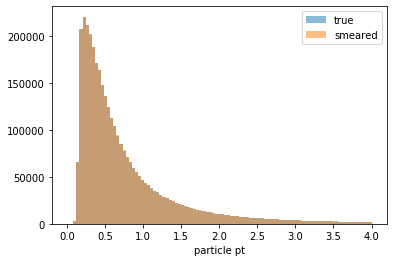

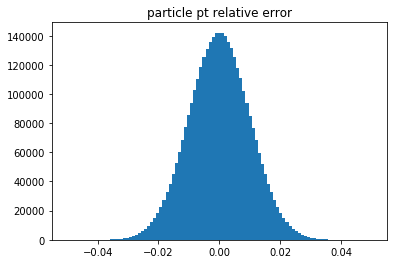

In [8]:
# particle pt relative error
part_pt_tree = ur.open("%s:particle_pt"%(natural_file))
part_pt_df = part_pt_tree.arrays(library="pd")
part_pt_df = part_pt_df[part_pt_df['obs_pt'] != -9999]
part_pt = part_pt_df['gen_pt']
part_pt_smeared = part_pt_df['obs_pt']

binning = np.linspace(0, 4, 100)
plt.hist(part_pt, binning, alpha=0.5, label='true')
plt.hist(part_pt_smeared, binning, alpha=0.5, label='smeared')
plt.legend()
plt.xlabel('particle pt')
plt.show()

binning = np.linspace(-0.05, 0.05, 100)
plt.hist( (part_pt_smeared - part_pt) / part_pt, binning)
plt.title('particle pt relative error')
plt.show()

### Jet pt resolution

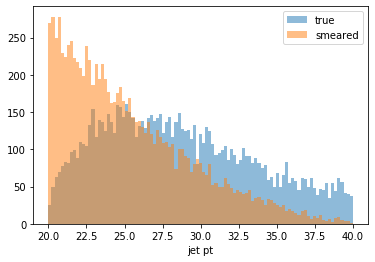

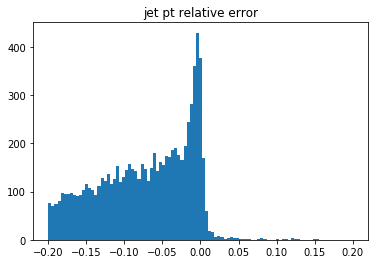

In [9]:
# jet pt relative error
jet_pt_tree = ur.open("%s:jet_pt"%(natural_file))
jet_pt_df = jet_pt_tree.arrays(library="pd")
jet_pt = jet_pt_df['gen_pt']
jet_pt_smeared = jet_pt_df['obs_pt']

binning = np.linspace(20, 40, 100)
plt.hist(jet_pt, binning, alpha=0.5, label='true')
plt.hist(jet_pt_smeared, binning, alpha=0.5, label='smeared')
plt.legend()
plt.xlabel('jet pt')
plt.show()

binning = np.linspace(-0.2, 0.2, 100)
plt.hist( (jet_pt_smeared - jet_pt) / jet_pt, binning)
plt.title('jet pt relative error')
plt.show()

### Import "synthetic simulation", both generated and reconstructed level.

In [10]:
synthetic_file = "preprocess_tr_eff.root"
synth_tree = ur.open("%s:preprocessed"%(synthetic_file))
synth_df = synth_tree.arrays(library="pd")
#synth_df = synth_df[synth_df["obs_hfs_pt"] != 0]

In [11]:
synth_df.tail(10) #look at some entries

,gen_energy_weight,gen_R_L,gen_jet_pt,obs_energy_weight,obs_R_L,obs_jet_pt,obs_thrown
3400165,0.002796,0.149768,31.200325,-9999.000000,-9999.000000,-9999.000000,1.0
3400166,0.012592,0.146687,31.200325,0.024495,0.152934,22.235663,0.0
3400167,0.007912,0.136102,31.200325,0.015866,0.130208,22.235663,0.0
3400168,0.001355,0.115010,31.200325,-9999.000000,-9999.000000,-9999.000000,1.0
3400169,0.012661,0.078984,31.200325,0.025349,0.080094,22.235663,0.0
3400170,0.001590,0.134997,31.200325,0.003144,0.130856,22.235663,0.0
3400171,0.002385,0.087659,31.200325,-9999.000000,-9999.000000,-9999.000000,1.0
3400172,0.017098,0.090355,31.200325,0.034155,0.092468,22.235663,0.0
3400173,0.044636,0.049273,31.200325,-9999.000000,-9999.000000,-9999.000000,1.0
3400174,0.041894,0.000000,31.200325,0.083488,0.000000,22.235663,0.0


### define 4 main datasets

In [12]:
theta_unknown_S = natural_df[obs_features].to_numpy() #Reconstructed Data
theta_unknown_G = natural_df[gen_features].to_numpy() #Nature, which unfolded data approaches

theta0_S = synth_df[obs_features].to_numpy() #Simulated, synthetic reco-level
theta0_G = synth_df[gen_features].to_numpy() #Generated, synthetic truth-level

obs_thrown = synth_df['obs_thrown'].to_numpy() # binary if pair DOESN'T pass efficiency cut

### Ensure the samples have the same number of entries

In [13]:
N_Events = min(np.shape(theta0_S)[0],np.shape(theta_unknown_S)[0])-1

# Synthetic
theta0_S = theta0_S[:N_Events]
theta0_G = theta0_G[:N_Events]

theta0 = np.stack([theta0_S, theta0_G], axis=1)

# Natural
theta_unknown_S = theta_unknown_S[:N_Events]
theta_unknown_G = theta_unknown_G[:N_Events]

obs_thrown = obs_thrown[:N_Events]

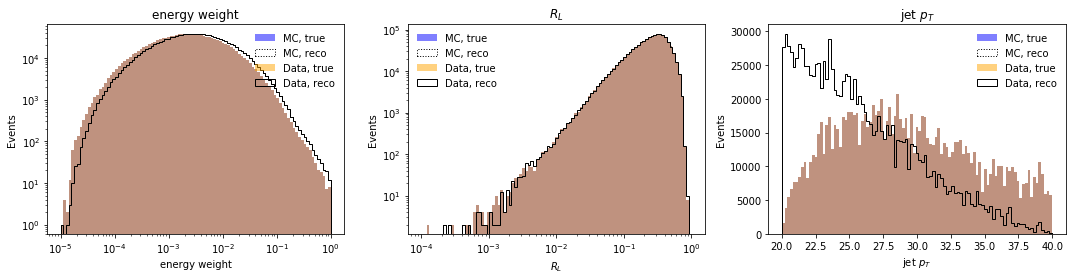

In [14]:
N = len(obs_features)

binning = [np.logspace(-5,0,100),np.logspace(-4,0,100),np.linspace(20,40,100)]

fig, axes = plt.subplots(1, 3, figsize=(15,4))

obs_i = 0

for i,ax in enumerate(axes.ravel()):
    if (i >= N): break
    _,_,_=ax.hist(theta0_G[:,i][obs_thrown!=1],binning[i],color='blue',alpha=0.5,label="MC, true")
    _,_,_=ax.hist(theta0_S[:,i][obs_thrown!=1],binning[i],histtype="step",color='black',ls=':',label="MC, reco")
    _,_,_=ax.hist(theta_unknown_G[:,i][obs_thrown!=1],binning[i],color='orange',alpha=0.5,label="Data, true")
    _,_,_=ax.hist(theta_unknown_S[:,i][obs_thrown!=1],binning[i],histtype="step",color='black',label="Data, reco")

    ax.set_title(labels[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Events")
    ax.legend(frameon=False)
    
    if obs_i in [0, 1]:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    obs_i += 1
    
fig.tight_layout()

In [15]:
inputs = Input((len(obs_features), ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_dis = Model(inputs=inputs, outputs=outputs)

In [20]:
print(theta0_G.shape)
print(theta0_S.shape)
print(theta_unknown_S.shape)

print(theta0_G[theta0_S[:,0]==-9999])
print(theta0_G[theta0_S[:,0]==-9999].shape)

(3400174, 3)
(3400174, 3)
(3400174, 3)
[[2.29056581e-05 0.00000000e+00 2.20149176e+01]
 [2.69241980e-05 1.73667071e-01 2.20149176e+01]
 [1.87007673e-04 6.64019675e-01 2.20149176e+01]
 ...
 [1.35526124e-03 1.15009940e-01 3.12003245e+01]
 [2.38519049e-03 8.76589961e-02 3.12003245e+01]
 [4.46358952e-02 4.92727065e-02 3.12003245e+01]]
(2172604, 3)


In [ ]:
N_Iterations = 2
myweights = of.omnifold_tr_eff(theta0,theta_unknown_S,N_Iterations,model_dis,dummyval=-9999)


ITERATION: 1

STEP 1

runs now
[[2.35466026e-05 2.65095121e-01 2.81622315e+01]
 [1.02254192e-02 1.34083059e-01 3.01196236e+01]
 [1.91458727e-02 2.64405850e-01 2.25236841e+01]
 ...
 [2.93048252e-05 1.67565574e-01 2.84436850e+01]
 [1.95109587e-03 4.79766939e-01 2.95073615e+01]
 [1.99004789e-03 2.03169941e-01 2.28766395e+01]]
[0. 0. 0. ... 0. 0. 1.]
[1. 1. 1. ... 1. 1. 1.]


In [ ]:
for iteration in range(N_Iterations):
    fig, axes = plt.subplots(1, 3, figsize=(15,4))

    obs_i = 0

    for i,ax in enumerate(axes.ravel()):
        if (i >= N): break
        _,_,_=ax.hist(theta0_G[:,i],binning[i],color='blue',alpha=0.5,label="MC, true")
        _,_,_=ax.hist(theta_unknown_G[:,i],binning[i],color='orange',alpha=0.5,label="Data, true")
        _,_,_=ax.hist(theta0_G[:,i],weights=myweights[iteration, 0, :],bins=binning[i],color='black',histtype="step",label="OmniFolded",lw="2")

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("Events")
        ax.legend(frameon=False)

        if obs_i in [0, 1]:
            ax.set_xscale('log')
            ax.set_yscale('log')

        obs_i += 1
    
    fig.tight_layout()

___
___

### true vs smeared EEC calculation

In [ ]:
binning = np.logspace(-4, np.log10(0.4), 100)

_,_,_=plt.hist(theta0_G[:,1], binning, weights=theta0_G[:,0], color='blue', alpha=0.5, label="MC, true") # true
_,_,_=plt.hist(theta0_S[:,1], binning, weights=theta0_S[:,0], color='orange', alpha=0.5, label="data, smeared") # smeared
_,_,_=plt.hist(theta0_G[:,1] * myweights[-1, 0, :], binning, weights=theta0_G[:,0] * myweights[-1, 0, :], color='black', histtype="step", label="OmniFolded", lw="2") # omnifolded

plt.xscale('log')
plt.yscale('log')

plt.xlabel("$R_L$")
plt.ylabel("cs")
plt.title("EEC calculation")
plt.legend(frameon=False, loc='upper left')

In [ ]:
myweights[-1]

In [ ]:
myweights

In [ ]:
pass_reco = np.random.binomial(1,0.9,30)

In [ ]:
pass_reco